In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import cv2

2025-06-28 20:56:16.086869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-28 20:56:18.403847: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-28 20:56:19.362032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751122579.946099   13236 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751122580.186230   13236 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-28 20:56:22.199378: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Load Image

In [2]:
def load_image(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(img_array.copy())
    return img_array / 255.0, tf.convert_to_tensor([img_preprocessed], dtype=tf.float32)

### load the model and last convulotion layer

In [3]:
# Load model and get last conv layer
model = MobileNetV2(weights='imagenet')
last_conv_layer = model.get_layer('Conv_1')

2025-06-28 20:56:47.600162: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Grad-CAM and heatmap

In [4]:
def compute_gradcam(model, img_tensor, class_index):
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_heatmap(original, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap_color * alpha + (original * 255)
    return np.uint8(superimposed)

### IG functions

In [5]:
@tf.function
def interpolate_images(baseline, image, alphas):
    delta = image - baseline
    return baseline + alphas[:, None, None, None] * delta

@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        outputs = predictions[:, target_class_idx]
    return tape.gradient(outputs, images)

def integrated_gradients(image, baseline=None, target_class_idx=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(image)
    alphas = tf.linspace(0.0, 1.0, steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx)
    avg_grads = tf.reduce_mean(grads, axis=0)
    return (image - baseline)[0] * avg_grads

### Ploting Image

In [6]:
def plot_ig(ig, original):
    ig = tf.reduce_sum(tf.abs(ig), axis=-1)
    ig = (ig - tf.reduce_min(ig)) / (tf.reduce_max(ig) - tf.reduce_min(ig))
    plt.imshow(original)
    plt.imshow(ig, cmap='hot', alpha=0.5)
    plt.axis('off')

### Adversarial attack

In [7]:
def adversarial_attack(image, label_index, epsilon=0.01):
    image_var = tf.Variable(image)
    with tf.GradientTape() as tape:
        prediction = model(image_var)
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            tf.constant([label_index]), prediction
        )
    gradient = tape.gradient(loss, image_var)
    signed_grad = tf.sign(gradient)
    adv_image = image_var + epsilon * signed_grad
    return tf.clip_by_value(adv_image, -1.0, 1.0)

In [15]:
img_rgb, img_tensor = load_image("/home/nasir/Semester 4.2/Deep learning/lab/images.jpeg")
class_index = 345

In [16]:
preds = model(img_tensor)
decoded = decode_predictions(preds.numpy())[0]
label_orig, desc_orig, score_orig = decoded[0]
print("Original prediction:", decoded[0])

Original prediction: ('n02504458', 'African_elephant', 0.3746864)


In [17]:
heatmap = compute_gradcam(model, img_tensor, class_index)
ig_map = integrated_gradients(img_tensor, target_class_idx=class_index)

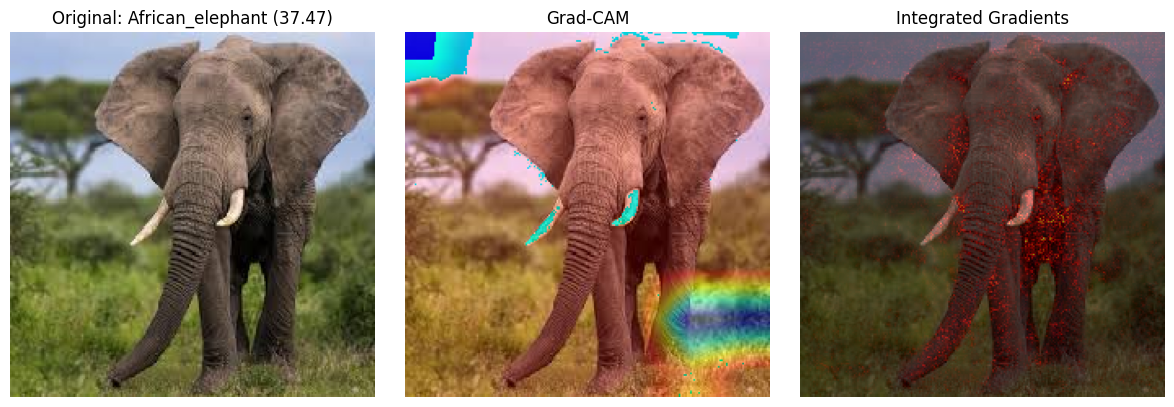

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title(f"Original: {desc_orig} ({score_orig * 100:.2f})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(show_heatmap(img_rgb, heatmap))
plt.title("Grad-CAM")
plt.axis('off')

plt.subplot(1, 3, 3)
plot_ig(ig_map, img_rgb)
plt.title("Integrated Gradients")
plt.tight_layout()
plt.show()

### After Adversarial

In [19]:
adv_img = adversarial_attack(img_tensor, class_index)
adv_preds = model(adv_img)
decoded_adv = decode_predictions(adv_preds.numpy())[0]
label_adv, desc_adv, score_adv = decoded_adv[0]
print("Adversarial prediction:", decoded_adv[0])

adv_heatmap = compute_gradcam(model, adv_img, class_index)
adv_ig_map = integrated_gradients(adv_img, target_class_idx=class_index)

Adversarial prediction: ('n02504458', 'African_elephant', 0.76591927)


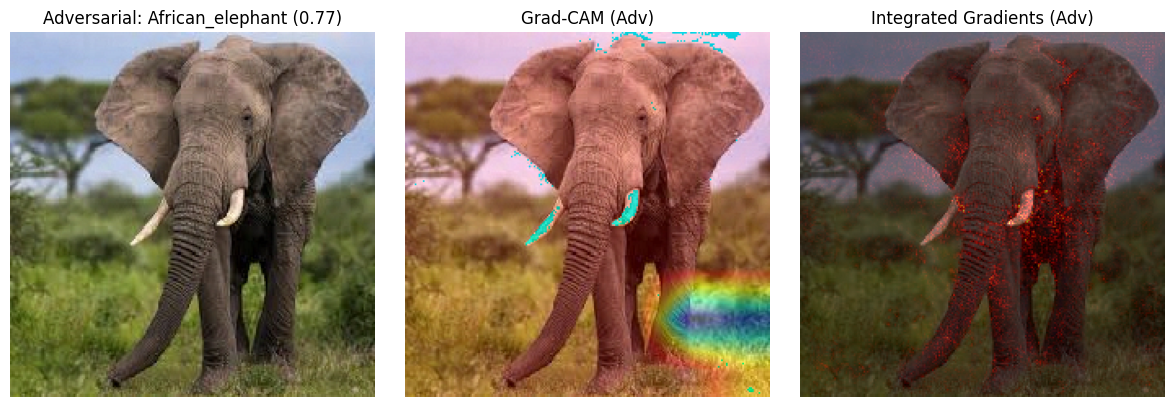

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow((adv_img[0].numpy() + 1) / 2)  # Convert from [-1,1] to [0,1]
plt.title(f"Adversarial: {desc_adv} ({score_adv:.2f})")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(show_heatmap((adv_img[0].numpy() + 1) / 2, adv_heatmap))
plt.title("Grad-CAM (Adv)")
plt.axis('off')

plt.subplot(1, 3, 3)
plot_ig(adv_ig_map, (adv_img[0].numpy() + 1) / 2)
plt.title("Integrated Gradients (Adv)")
plt.tight_layout()
plt.show()